In [1]:
import json
import pickle

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tifffile
from tqdm.auto import tqdm
import cv2
import random
import math

In [2]:
def letterbox(img, height, width):  # resize a rectangular image to a padded rectangular
    shape = img.shape[:2]  # shape = [height, width]
    ratio = min(float(height) / shape[0], float(width) / shape[1])
    new_shape = (round(shape[1] * ratio), round(shape[0] * ratio))  # new_shape = [width, height]
    dw = (width - new_shape[0]) / 2  # width padding
    dh = (height - new_shape[1]) / 2  # height padding
    top, bottom = round(dh - 0.1), round(dh + 0.1)
    left, right = round(dw - 0.1), round(dw + 0.1)
    img = cv2.resize(img, new_shape, interpolation=cv2.INTER_AREA)  # resized, no border
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=1)  # padded rectangular
    return img, ratio, dw, dh

In [136]:
def random_affine(img, targets=None, degrees=(-90, 90), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10)):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    border = 0  # width of added border (optional)
    height = img.shape[0]
    width = img.shape[1]

    # Rotation and Scale
    R = np.eye(3)
    a = random.random() * (degrees[1] - degrees[0]) + degrees[0]
    # a += random.choice([-180, -90, 0, 90])  # 90deg rotations added to small rotations
    s = random.random() * (scale[1] - scale[0]) + scale[0]
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = (random.random() * 2 - 1) * translate[0] * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = (random.random() * 2 - 1) * translate[1] * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan((random.random() * (shear[1] - shear[0]) + shear[0]) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan((random.random() * (shear[1] - shear[0]) + shear[0]) * math.pi / 180)  # y shear (deg)

    M = S @ T @ R  # Combined rotation matrix. ORDER IS IMPORTANT HERE!!
    imw = cv2.warpPerspective(img, M, dsize=(width, height), flags=cv2.INTER_LINEAR,
                              borderValue=1)  # BGR order borderValue

    # Return warped points also
    if targets is not None:
        if len(targets) > 0:

            # warp points
            n = targets.shape[0]
            xy = np.ones((n, 3))
            xy[:, :2] = targets[:, :]
            xy = (xy @ M.T)

            # reject warped points outside of image            
            i = (xy[:, 0] > 0) & (xy[:, 0] < width) & (xy[:, 1] > 0) & (xy[:, 1] < height)
            
            targets = targets[i]
            targets[:, :] = xy[i, :2]

        return imw, targets, M
    else:
        return imw


In [137]:
# データの読み込み
idx = 24
data = tifffile.imread(f'./train_images/train_{idx:02d}.tif')[..., np.newaxis]/65536*2 - 1
points0 = []
with open(f"./train_annotations/train_{idx:02d}.json", "r") as fp:
    annotation = json.load(fp)
    
    for point in annotation['coastline_points']:
        points0.append(point)
points0 = np.array(points0)

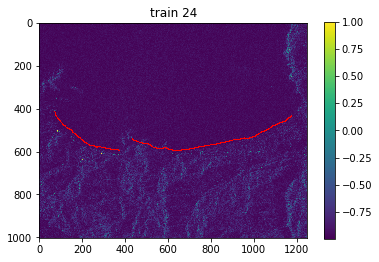

In [35]:
# プロット
plt.title(f"train {idx:02d}")
plt.imshow(np.squeeze(data))
for point in points0:
    plt.plot(point[0], point[1], ",", color="red")
plt.colorbar()
plt.show()

In [53]:
# データの型、サイズ
type(data), data.shape

(numpy.ndarray, (1003, 1250, 1))

In [54]:
np.max(data)

1.0

In [55]:
np.min(data)

1.52587890625e-05

In [36]:
height=416
width=640

In [138]:
data, ratio, padw, padh = letterbox(data, height=height, width=width)

In [139]:
points = points0.copy()
points[:, 0] = ratio * points0[:, 0] + padw
points[:, 1] = ratio * points0[:, 1] + padh

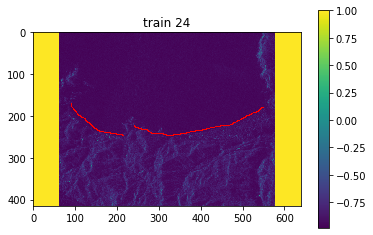

In [8]:
# プロット
plt.title(f"train {idx:02d}")
plt.imshow(np.squeeze(data))
for point in points:
    plt.plot(point[0], point[1], ",", color="red")
plt.colorbar()
plt.show()

In [144]:
data, points, M = random_affine(data, points)

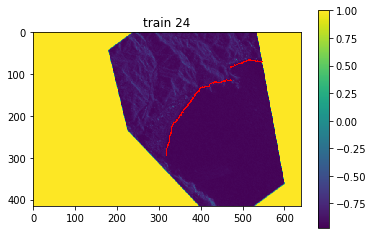

In [145]:
# プロット
plt.title(f"train {idx:02d}")
plt.imshow(np.squeeze(data))
for point in points:
    plt.plot(point[0], point[1], ",", color="red")
plt.colorbar()
plt.show()

In [142]:
data = np.fliplr(data)
points[:, 0] = width - points[:, 0]

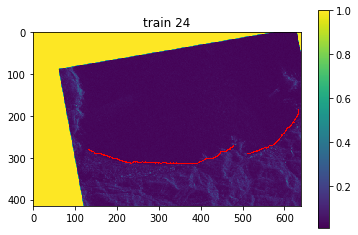

In [143]:
# プロット
plt.title(f"train {idx:02d}")
plt.imshow(np.squeeze(data))
for point in points:
    plt.plot(point[0], point[1], ",", color="red")
plt.colorbar()
plt.show()

In [124]:
def gaussian_radius1(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 + sq1) / 2

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 + sq2) / 2

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / 2
  print(r1, r2, r3)
  return min(r1, r2, r3)

def gaussian_radius2(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 - sq1) / (2 * a1)

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 - sq2) / (2 * a2)

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / (2 * a3)
  print(r1, r2, r3)
  return min(r1, r2, r3)

def simple_gaussian_radius(det_size):
    height, width = det_size
    rh=0.1155*height
    rw=0.1155*width
    print(rh, rw)
    return rh, rw

def simple_gaussian2D(shape, sigmah=1, sigmaw=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x / (2 * sigmaw * sigmaw)+ y * y / (2 * sigmah * sigmah)))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap

def simple_draw_umich_gaussian(heatmap, center, rh, rw, k=1):
    diameterh = 2 * rh + 1
    diameterw = 2 * rw + 1
  
    gaussian = simple_gaussian2D((diameterh, diameterw), sigmah=diameterh / 6, sigmaw=diameterw / 6)
  
    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]
    
    left, right = min(x, rw), min(width - x, rw + 1)
    top, bottom = min(y, rh), min(height - y, rh + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[rh - top:rh + bottom, rw - left:rw + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

In [15]:
import torch

In [41]:
print(points)

[[138 140]
 [138 142]
 [138 142]
 ...
 [402 212]
 [402 212]
 [403 212]]


In [28]:
points[:, 0] = points[:, 0] / width
points[:, 1] = points[:, 1] / height

In [126]:
img = torch.from_numpy(data.astype(np.float32)).clone()

down_ratio = 4
output_h = img.shape[0] // down_ratio
output_w = img.shape[1] // down_ratio
num_classes = 1
hm = np.zeros((num_classes, output_h, output_w), dtype=np.float32)
hm.shape

num_objs = points.shape[0]
cls_id = 0

for k in range(num_objs):
    point = points[k]
    h = 20
    w = 20

    #radius = gaussian_radius1((math.ceil(h), math.ceil(w)))
    #radius = gaussian_radius2((math.ceil(h), math.ceil(w)))
    rh, rw = simple_gaussian_radius((math.ceil(h), math.ceil(w)))
    #radius = max(0, int(radius))
    rh = max(0, int(rh))
    rw = max(0, int(rw))
    point = np.array([point[0] // down_ratio, point[1] // down_ratio], dtype=np.float32)
    point_int = point.astype(np.int32)
    simple_draw_umich_gaussian(hm[cls_id], point_int, rh, rw)

1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.155 1.155
1.15

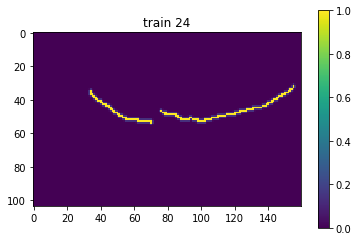

In [130]:
# プロット
# 画像のプロット先の準備
fig = plt.figure()
plt.title(f"train {idx:02d}")
plt.imshow(np.squeeze(hm))
plt.colorbar()
plt.show()
# グラフをファイルに保存する
fig.savefig("heatmap.png")

In [129]:
img = torch.from_numpy(data.astype(np.float32)).clone()
img.unsqueeze(0).shape

torch.Size([1, 416, 640])

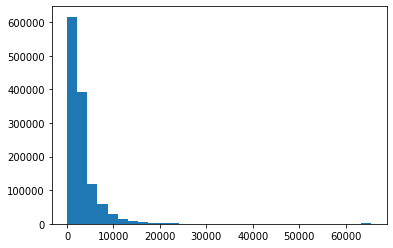

In [49]:
# 輝度のヒストグラム
plt.hist(data.flatten(), bins=30)
plt.show()

65537


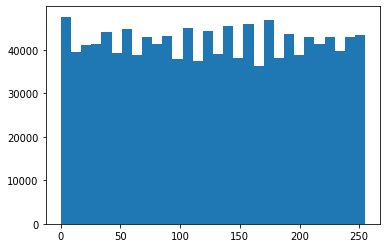

In [50]:
# ヒストグラム平坦化
# hist,bins = np.histogram(data.flatten(),65537,[0,65537])

# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()

# cdf_m = np.ma.masked_equal(cdf,0)
# cdf_m = (cdf_m - cdf_m.min())*65537/(cdf_m.max()-cdf_m.min())
# cdf = np.ma.filled(cdf_m,0).astype('uint8')

# print(len(cdf))

# data_equalize = cdf[data]

# plt.hist(data_equalize.flatten(), bins=30)
# plt.show()

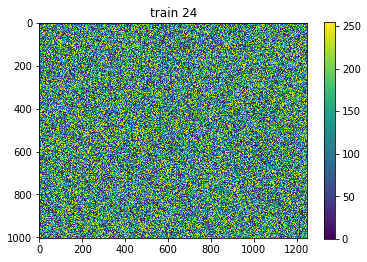

In [51]:
# plt.title(f"train {idx:02d}")
# plt.imshow(data_equalize)
# plt.colorbar()
# plt.show()

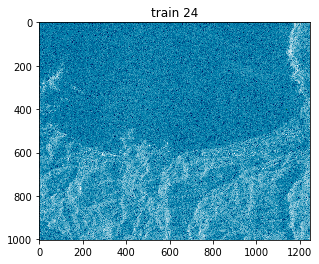

In [52]:
# ログスケールでの可視化
plt.title(f"train {idx:02d}")
plt.imshow(np.log10(data + 1.0e-1), cmap="ocean")
plt.show()

265
7956


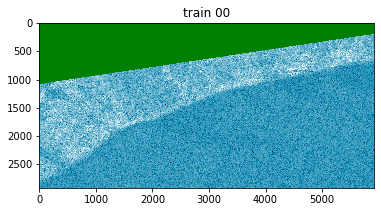

In [18]:
# annotationデータのプロット
plt.title(f"train {idx:02d}")
plt.imshow(np.log10(data + 1.0e-1), cmap="ocean")
print(len(annotation['validate_lines']))
# for line in annotation['validate_lines']:
#     ix = [line[i][0] for i in range(2)]
#     iy = [line[i][1] for i in range(2)]
#     plt.plot(ix, iy)
print(len(annotation['coastline_points']))
# for point in annotation['coastline_points']:
#     plt.plot(point[0], point[1], ",", color="red")
plt.show()

65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536
65536


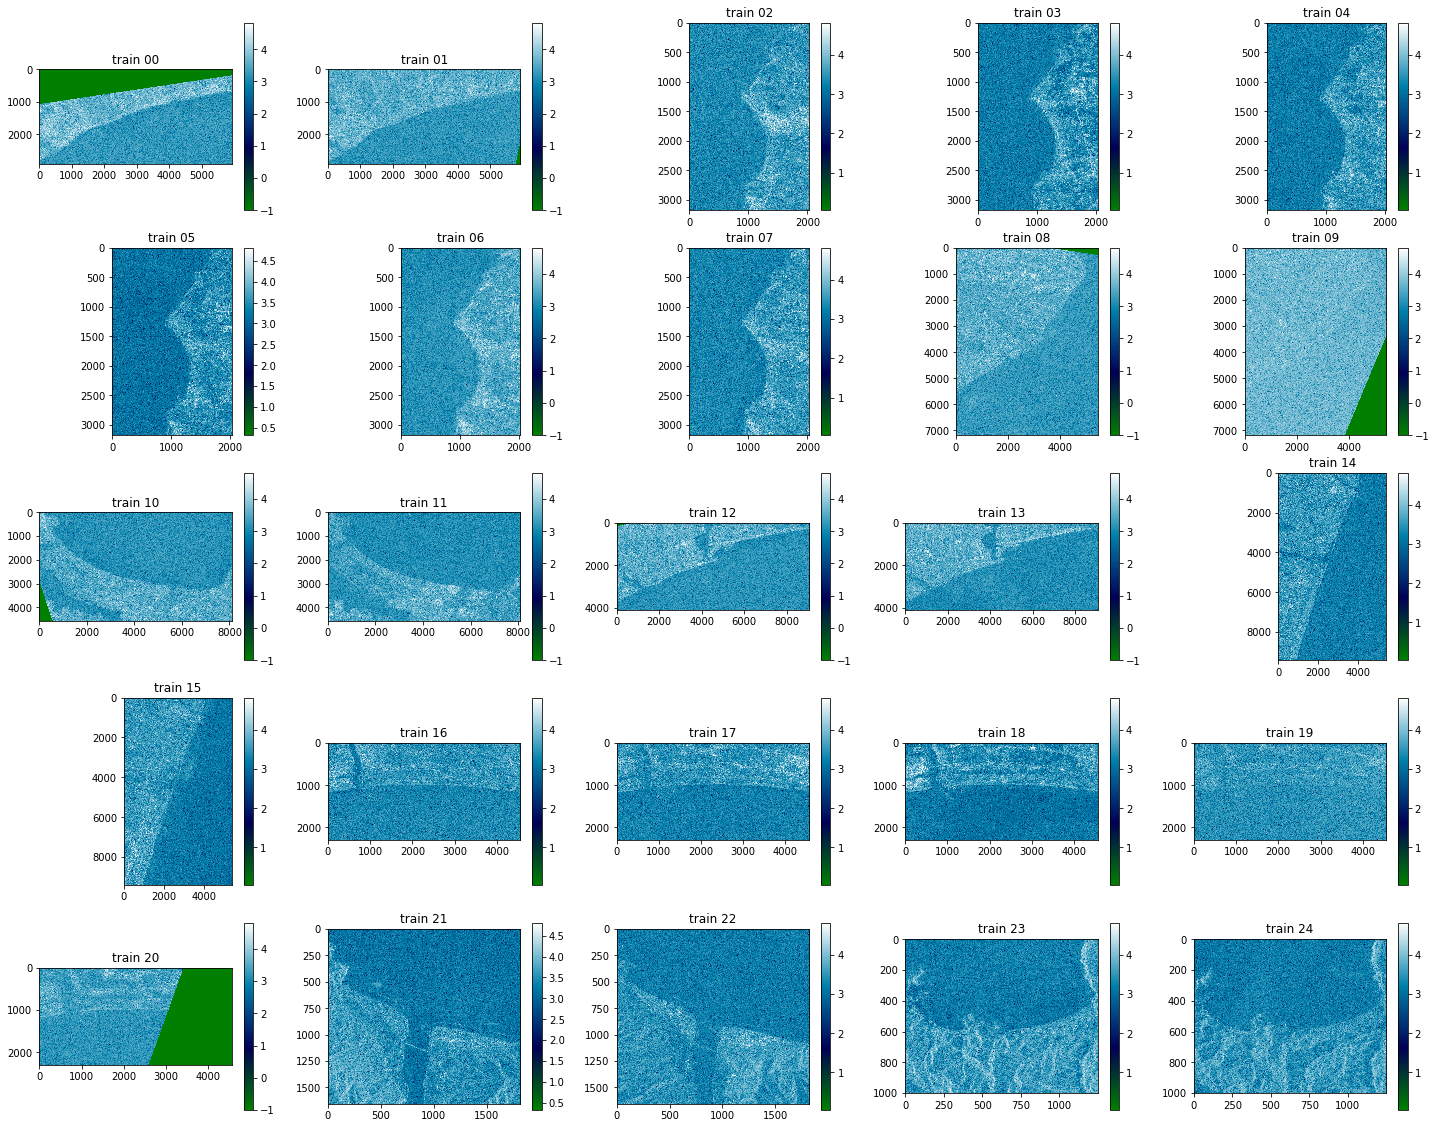

In [8]:
# trainデータ全体の可視化
plt.figure(figsize=(5*5,5*4))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.title(f"train {idx:02d}")
    data = tifffile.imread(f'./train_images/train_{idx:02d}.tif')
    print(np.max(data))
    plt.imshow(np.log10(data + 1.0e-1), cmap="ocean")
    plt.colorbar()
#plt.savefig("./image.png")
plt.show()

In [ ]:
# trainデータ全体の可視化
plt.figure(figsize=(5*5,5*4))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.title(f"train {idx:02d}")
    data = tifffile.imread(f'./train_images/train_{idx:02d}.tif')
    with open(f"./train_annotations/train_{idx:02d}.json", "r") as fp:
        annotation = json.load(fp)
    plt.imshow(np.log10(data + 1.0e-1), cmap="ocean")
    for line in annotation['validate_lines']:
        ix = [line[i][0] for i in range(2)]
        iy = [line[i][1] for i in range(2)]
        plt.plot(ix, iy)
    for point in annotation['coastline_points']:
        plt.plot(point[0], point[1], ",", color="red")
    plt.colorbar()
#plt.savefig("./image_w_annotate.png")
plt.show()

65535
65535
65535
65536
65535
65535
65535
65536
65535
65535
65536
65535
65535
65535
65535
65535
65535
65535
65535
65535
65535
65535
65535
65535
65535
65535
65536
65535
65535
65535


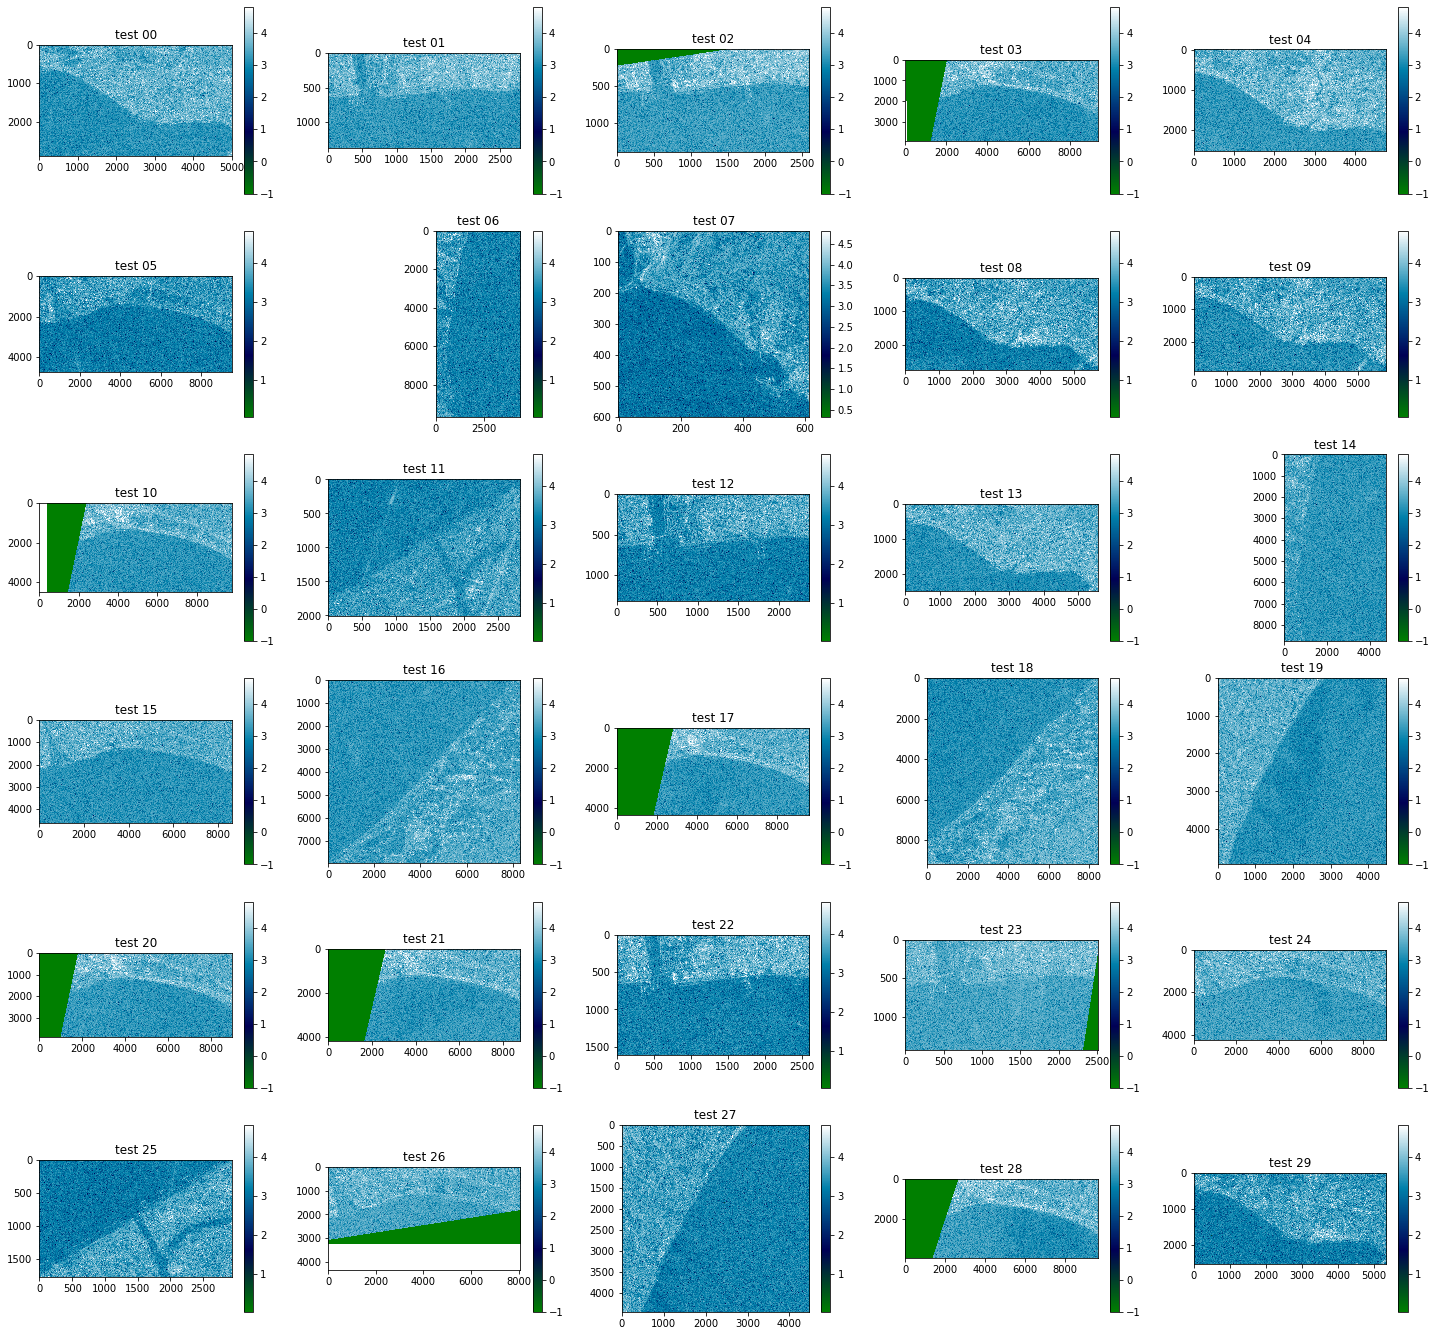

In [10]:
# testデータ全体の可視化
plt.figure(figsize=(5*5,6*4))
for idx in range(30):
    plt.subplot(6,5,idx+1)
    plt.title(f"test {idx:02d}")
    data = tifffile.imread(f'./test_images/test_{idx:02d}.tif')
    print(np.max(data))
    plt.imshow(np.log10(data + 1.0e-1), cmap="ocean")
    plt.colorbar()
#plt.savefig("./test_image.png")
plt.show()